## Exercise 13: The Variational Quantum Eigensolver (VQE)

In this exercise we are going to see how variational methods can be used in a hybrid quantum-classical scheme in order to approximate quantum states.

In particular the aim of the Variational Quantum Eigensolver (VQE) is to optimize a set of parameterized quantum gates to approximate the ground state of a quantum system, given that the expectation value of the energy and its derivatives with respect to the parameters are evaluated on a quantum hardware in a scalable way.

Preparing ground state is an exponentially complex task even on a quantum computer (QMA), but the VQE is expected to give some advantage for specific tasks in physics, chemistry and/or material sciences.

### Classical simulation of $H_2$

Here we will recall the code for the classical simulation of the dissociation process of $H_2$ diatomic molecule.

In [1]:
!pip install pyscf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 259.1 kB/s eta 0:00:0000:0100:04


In [2]:
import numpy as np
from pyscf import gto,scf,ao2mo,mp,cc,fci,tools
import matplotlib.pyplot as plt

np.set_printoptions(precision=2,suppress=1e-8,linewidth=120)

In [3]:
## Define a set of distances between the two atoms

distances = np.arange(0.3, 4, .05)

## and a basis in which the calculations will be made

basis = '6-31g' #'6-31g' 'cc-pvdz' 'aug-cc-pvdz' ,...

## Define a dictionary containing the energies derived with different methods
energies = {}

In [4]:
energies["HF_"+basis]   = []
energies["FCI_"+basis]  = []
energies["CCSD_"+basis] = []

for (i,r) in enumerate(distances):
    # Build the 3D geometry of the molecule
    geometry = "H .0 .0 .0; H .0 .0 "+str(r)
    # And pass it to the gaussian orbitals generator (this is an alternative way to create the molecule object)
    mol = gto.M(atom=geometry,charge=0,spin=0,basis=basis,symmetry=True,verbose=0)

    mf  = scf.RHF(mol) # Initialise a Restricted HF calculation using the molecule constructed
    Ehf = mf.kernel()  #<- calling the kernel we compute the energy using the orbitals obtained

    fci_h2 = fci.FCI(mf) # FCI calculation
    Efci = fci_h2.kernel()[0]


    ccsd_h2 = cc.CCSD(mf) # CCSD calculation
    e_ccsd  = ccsd_h2.kernel()[0]
    e_ccsd += Ehf # <- this lines is mandatory because CCSD computes the energy difference with HF


    # Save energies
    energies["HF_"+basis].append(Ehf)
    energies["FCI_"+basis].append(Efci)
    energies["CCSD_"+basis].append(e_ccsd)

/Users/mufeedamir/miniconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/mufeedamir/miniconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


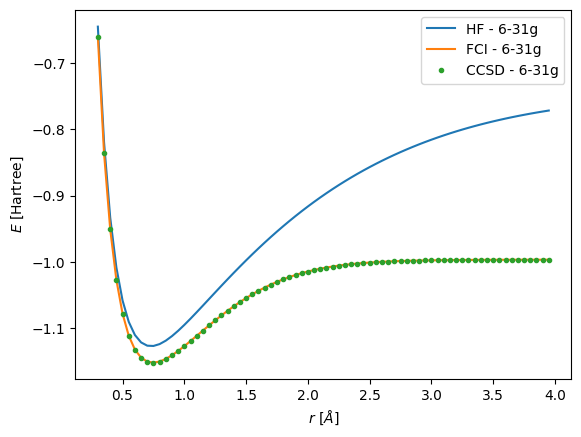

In [5]:
## Now plot the result

plt.plot(distances,energies["HF_"+basis],label="HF - "+basis)
plt.plot(distances,energies["FCI_"+basis],label="FCI - "+basis)
plt.plot(distances,energies["CCSD_"+basis],label="CCSD - "+basis,linestyle="",marker=".")

plt.xlabel(r"$r$ [$\AA$]")
plt.ylabel(r"$E$ [Hartree]")
plt.legend()
plt.show()

As can be seen, the CCSD calculation is as accurate as FCI in this small system.

### Quantum simulation of $H_2$

Now we will proceed to the simulation on the quantum computer.

As showed [here](https://www.nature.com/articles/nature23879) the Variational quantum eigensolver can be used to calculate dissociation processes of small molecules on quantum processor.

In [6]:
!pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 935.9 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 674.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 625.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 475.7 kB/s eta 0:00:00:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.7/22.7 MB 828.2 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [7]:
!pip install qiskit_aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 616.8 kB/s eta 0:00:0000:0100:01


In [8]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp # To create operators
from qiskit.primitives import Estimator       # to estimate expectation values

#### Preparing the Hamiltonian

First, since we want to study a fermionic system on a set of qubits, we must find a mapping between the two.

The oldest mapping proposed is the Jordan-Wigner, which was illustrated also in the lectures, but there are many others.

Two noticeable alternatives are the [parity mapping](https://iopscience.iop.org/article/10.1088/1367-2630/aac54f) and the [Bravyi-Kitaev mapping](https://pubs.acs.org/doi/10.1021/acs.jctc.8b00450).

In particular, we are going to focus on the parity mapping for the $H_2$ system.

Instead of storing the occupation of a fermionic state $f_{j}$, as Jordan-Wigner does, this isomorphism uses the qubits to store the quantity
\begin{equation}
\label{eq:parity}
p_{j}=\sum_{i=0}^{j-1}f_{i} \mod 2 \quad ,
\end{equation}
called parity of the set of occupation numbers $f_{j-1}\dots f_{0}$.

This is convenient for system like $H_2$ which conserve the total number of electrons with fixed spin orientation, meaning that we can get rid of two qubits out of the box.

Manually performing the mapping can be a very tedious and prone-to-error task, for this reason we will use the very practical Qiskit PySCF driver, which recalls the creation of a PySCF molecule object that we have seen in previous lectures but gives a qubit operator ready to be measured on a quantum computer.

This driver can be found in the Qiskit optional package `nature`.

In [9]:
!pip install 'qiskit-nature'
!pip install 'pylatexenc'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 805.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136819 sha256=02e9192fb4866ba314f60f59784add32f8c7a7883418a6e79cb90c06650fb35c
  Stored in directory: /Users/mufeedamir/Library/Caches/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [10]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

In [11]:
# Initialise the molecule using the PySCF driver

molecule = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)], charge=0, multiplicity=1)
driver = PySCFDriver.from_molecule(molecule, basis="6-31g")
problem = driver.run()

In [12]:
# Now the problem has also the nuclear repulsion shift of the Born-Oppenheimer approximation
problem.nuclear_repulsion_energy

0.7199689944489797

In [13]:
## Calling .second_q_ops will generate a bunch of operators such as dipole, magnetization, ...
## We only need the Hamiltonian
hamiltonian = problem.second_q_ops()[0]

In [14]:
print(hamiltonian)

Fermionic Operator
number spin orbitals=8, number terms=528
  -1.249438409117857 * ( +_0 -_0 )
+ -0.16790838263947508 * ( +_0 -_2 )
+ -0.5478161383553163 * ( +_1 -_1 )
+ -0.2075017169257064 * ( +_1 -_3 )
+ -0.16790838263947513 * ( +_2 -_0 )
+ -0.18307468571442784 * ( +_2 -_2 )
+ -0.20750171692570643 * ( +_3 -_1 )
+ 0.21843865525265574 * ( +_3 -_3 )
+ -1.249438409117857 * ( +_4 -_4 )
+ -0.16790838263947508 * ( +_4 -_6 )
+ -0.5478161383553163 * ( +_5 -_5 )
+ -0.2075017169257064 * ( +_5 -_7 )
+ -0.16790838263947513 * ( +_6 -_4 )
+ -0.18307468571442784 * ( +_6 -_6 )
+ -0.20750171692570643 * ( +_7 -_5 )
+ 0.21843865525265574 * ( +_7 -_7 )
+ 0.32604923282937104 * ( +_0 +_0 -_0 -_0 )
+ 0.0839541105331589 * ( +_0 +_0 -_2 -_0 )
+ 0.21676828227393619 * ( +_0 +_1 -_1 -_0 )
+ 0.07168432208999226 * ( +_0 +_1 -_3 -_0 )
+ 0.0839541105331589 * ( +_0 +_2 -_0 -_0 )
+ 0.2662545261011093 * ( +_0 +_2 -_2 -_0 )
+ 0.07168432208999226 * ( +_0 +_3 -_1 -_0 )
+ 0.33271408240501166 * ( +_0 +_3 -_3 -_0 )
+ 0.32604

In [15]:
## Now we will map the problem to a qubit operator
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper, ParityMapper

In [16]:
## Create the qubit operator
#mapper = JordanWignerMapper()
#mapper = BravyiKitaevMapper()
mapper = ParityMapper()
qubit_op = mapper.map(hamiltonian)
print(qubit_op)

SparsePauliOp(['IIIIIIII', 'IIIIIIIZ', 'IIIIIZXX', 'IIIIIIYY', 'IIIIIIZZ', 'IIIIZXXZ', 'IIIIIYYI', 'IIIIIZZI', 'IIIIZZII', 'IIIZZIII', 'IZXXZIII', 'IIYYIIII', 'IIZZIIII', 'ZXXZIIII', 'IYYIIIII', 'IZZIIIII', 'ZZIIIIII', 'IIIIIIZI', 'IIIIZXXI', 'IIIIIYYZ', 'IIIIIZZZ', 'IIIIZZIZ', 'IIIZZIIZ', 'IZXXZIIZ', 'IIYYIIIZ', 'IIZZIIIZ', 'ZXXZIIIZ', 'IYYIIIIZ', 'IZZIIIIZ', 'ZZIIIIIZ', 'IIIIIZYY', 'IIIIIIXX', 'IIIIZXIX', 'IIIIIXZX', 'IIIIZYIY', 'IIIIIYIY', 'IIIIZXZX', 'IIIIIXIX', 'IIZXZIZX', 'IIIXIIZX', 'IIZXZIIX', 'IIIXIIIX', 'ZXXXZIZX', 'IYXYIIZX', 'ZXXXZIIX', 'IYXYIIIX', 'IZXZIIZX', 'IIXIIIZX', 'IZXZIIIX', 'IIXIIIIX', 'ZXZIIIZX', 'IXIIIIZX', 'ZXZIIIIX', 'IXIIIIIX', 'IIIIZIXX', 'IIIIZZYY', 'IIIZZZXX', 'IIIZZIYY', 'IZXXZZXX', 'IIYYIZXX', 'IZXXZIYY', 'IIYYIIYY', 'IIZZIZXX', 'IIZZIIYY', 'ZXXZIZXX', 'IYYIIZXX', 'ZXXZIIYY', 'IYYIIIYY', 'IZZIIZXX', 'IZZIIIYY', 'ZZIIIZXX', 'ZZIIIIYY', 'IIZXIXXX', 'IIIXZXXX', 'IIZXZYXY', 'IIIXIYXY', 'ZXXXIXXX', 'IYXYZXXX', 'ZXXXZYXY', 'IYXYIYXY', 'IZXZZXXX', 'IIXIZXXX', '

In [17]:
## Create the qubit operator (With 2 qubit reduction)
mapper = ParityMapper(num_particles=problem.num_particles) # Parity mapper requires the spin up and down electrons
qubit_op = mapper.map(hamiltonian)
print(qubit_op)

SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIZXX', 'IIIIYY', 'IIIIZZ', 'IIIXXZ', 'IIIYYI', 'IIIZZI', 'IIIZII', 'IIZIII', 'ZXXIII', 'IYYIII', 'IZZIII', 'XXZIII', 'YYIIII', 'ZZIIII', 'ZIIIII', 'IIIIZI', 'IIIXXI', 'IIIYYZ', 'IIIZZZ', 'IIIZIZ', 'IIZIIZ', 'ZXXIIZ', 'IYYIIZ', 'IZZIIZ', 'XXZIIZ', 'YYIIIZ', 'ZZIIIZ', 'ZIIIIZ', 'IIIZYY', 'IIIIXX', 'IZXIZX', 'IIXIZX', 'IZXIIX', 'IIXIIX', 'XXXIZX', 'YXYIZX', 'XXXIIX', 'YXYIIX', 'ZXZIZX', 'IXIIZX', 'ZXZIIX', 'IXIIIX', 'XZIIZX', 'XIIIZX', 'XZIIIX', 'XIIIIX', 'IIZZXX', 'IIZIYY', 'ZXXZXX', 'IYYZXX', 'ZXXIYY', 'IYYIYY', 'IZZZXX', 'IZZIYY', 'XXZZXX', 'YYIZXX', 'XXZIYY', 'YYIIYY', 'ZZIZXX', 'ZZIIYY', 'ZIIZXX', 'ZIIIYY', 'IZXXXX', 'IIXXXX', 'IZXYXY', 'IIXYXY', 'XXXXXX', 'YXYXXX', 'XXXYXY', 'YXYYXY', 'ZXZXXX', 'IXIXXX', 'ZXZYXY', 'IXIYXY', 'XZIXXX', 'XIIXXX', 'XZIYXY', 'XIIYXY', 'IIZIZZ', 'ZXXIZZ', 'IYYIZZ', 'IZZIZZ', 'XXZIZZ', 'YYIIZZ', 'ZZIIZZ', 'ZIIIZZ', 'IZXZXZ', 'IIXZXZ', 'IZXIXI', 'IIXIXI', 'XXXZXZ', 'YXYZXZ', 'XXXIXI', 'YXYIXI', 'ZXZZXZ', 'IXIZXZ', 'ZXZI

Now we have seen how to create a qubit operator for a single configuration, we will need to repeat this procedure for every $r$ in order to study the dissociation process of $H_2$.

#### Initial state

We need a starting point for our calculations, that in this case will be the Hartree-Fock (HF) determinant.
This can be easily prepared on the quantum circuit, since we are already in the basis of the HF orbitals.
This means that we will need to put an $X$ gate if the corresponding spin-orbital is occupied (Jordan-Wigner) or it has a odd occupation number (Parity).

Qiskit provides a useful `HartreeFock` function to create this initial state, that then we will pass to the VQE function.

In [18]:
from qiskit_nature.second_q.circuit.library.initial_states import HartreeFock

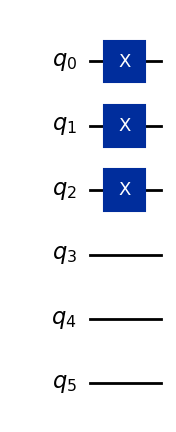

In [19]:
init_state = HartreeFock(num_spatial_orbitals=problem.num_spatial_orbitals, num_particles=problem.num_particles, qubit_mapper=mapper)
init_state.draw("mpl")

#### Variational wave function

Now that we have the Hamiltonian operator, we will need an ansatz for our wavefunction. Since we need a variational ansatz, some gates will contains parameters that are going to be iteratively optimized (as an example, rotation on the $x,y,z$ axis).

There is no analytical way to choose an ansatz for the system: there are empirical rules based on similarity with what we are studying.
Some ans&auml;tze come from classical computational chemistry, such as the highly accurate [q-UCCSD](https://arxiv.org/pdf/1506.00443.pdf),  but mostly we have to consider some circuits that can be run on current devices, so they have to contain few two qubits gates and be relatively shallow: these ans&auml;tze are called hardware-efficient.


What we are going to consider is one of the so-called "hardware-efficient ans&auml;tze".
The system does not contain many qubits, so our trial ansatz will be very simple : a layer of rotations around the $y$-axis followed by CNOTs and again a layer of rotations. This simple structure can be easily extended both in depth (adding more CNOTs and rotation) and in width, to study bigger system, therefore is widely used.

In [20]:
def variational_ansatz(n_qubits,params):

    qc = QuantumCircuit(n_qubits)

    for i in range(n_qubits):
        qc.ry(params[i],i)
    qc.barrier()
    for i in range(n_qubits-1):
        qc.cx(i,i+1)
    qc.barrier()
    for i in range(n_qubits):
        qc.ry(params[n_qubits+i],i)
    return qc

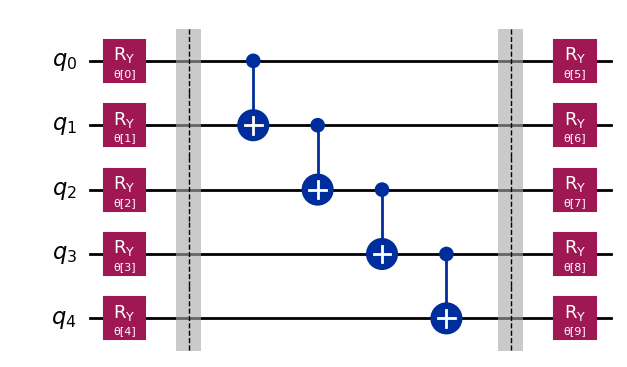

In [21]:
## Let's plot an example
qubits = 5
params = ParameterVector('θ',2*qubits)
variational_ansatz(qubits, params).draw("mpl")

#### Evaluating energy and the gradient

Now we focus on the core part of the VQE algorithm: the evaluation of the energy and of its gradient on the quantum hardware.

Qiskit has built-in methods for this, but we are going to implement ours from scratch.

First, we want a circuit to measure the expecation value of the Hamiltonian on our trial state

In [22]:
def energy(quantum_circuit, hamiltonian, parameters, estimator):
    ## This function evaluates the energy during a VQE calculation
    return estimator.run(quantum_circuit, hamiltonian, parameters).result().values[0]

In [23]:
## Example energy estimation
param_vec = ParameterVector("θ",4)
q_circuit = variational_ansatz(2,param_vec)
estimator = Estimator()

/var/folders/92/xj8_fzdx36b4vnm1kc6fp7600000gn/T/ipykernel_13949/3923375788.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Now things get interesting! In order to optimize our parameters $\theta$, a quantum computer has to give to classical optimizer important information such as first- or second-order derivatives! But how can we measure the derivative wrt to a specific parameter on a quantum circuit?

$$
\frac{\partial }{\partial \theta_i} L(\theta) = \frac{\partial }{\partial \theta_i} \langle \psi(\theta) | H | \psi(\theta) \rangle
$$

many different methods have been proposed recently, in this case we are going to see a method  that is called _parameter shift_:

- assume that every parametrized gate is of the form $$ U_j(\theta_j) = e^{-i \theta_j G_j}= \cos(\theta_j)\mathbf{I} -i \sin(\theta_j)G_j$$ where $G_j$ is an operator such that $G_{j}^{2} = \mathbf{I}$

- then the derivative can be expressed as $$ \frac{\partial }{\partial \theta_i} L(\theta) = \frac{L(\theta+ e_i s)-L(\theta-e_is)}{2\sin(s)}  $$ where $s \in \mathbf{R}$ and $e_i$ indicates the versor in the $i$-th direction. In our case we are going to consider $s= \frac{\pi}{2}$.

This means that to calculate the gradient with $N_p$ parameters, we have to measure $H$ on $2N_p$ different circuits, but it's possible!

Note that the assumption we made is quite general: $G_j$ could be every tensor product of Pauli operators

In [24]:
#useful function to shift the parameters
def ei(i,n):
    '''unit vector in direction i of size n'''
    vi = np.zeros(n)
    vi[i] = 1.0
    return vi[:]


def gradient(quantum_circuit, hamiltonian, parameters, estimator):

    n_parameters = len(parameters)
    g = np.zeros(n_parameters)

    for i in range(n_parameters):
        Ep  = energy(quantum_circuit, hamiltonian, parameters + ei(i,n_parameters)*np.pi/2.0, estimator)
        Em = energy(quantum_circuit, hamiltonian, parameters - ei(i,n_parameters)*np.pi/2.0, estimator)
        g[i] = (Ep-Em)/2.0
    return g

#### The VQE algorithm

Now we declare a function to repeat iteratively the procedure of measuring energy, its gradient and then optimizing the parameters using a standard gradient descent technique, namely $$ \theta_{new}= \theta_{old} - \eta \nabla_{\theta} L(\theta)$$ with $\eta \in \mathbf{R}$ as the learning rate.

In [25]:
import matplotlib.pyplot as plt

In [26]:
def VQE(operator=None, ansatz=None, init_params=None, init_state=None, estimator=None, max_iter=100, lr=0.1):

    """
    Args:
        operator: the hamiltonian as a qubit operator
        ansatz: the variational ansatz
        init_params: the initital parameters
        init_state: circuit to prepare the initial state (e.g. the Hartree-Fock state)
        estimator: qiskit Estimator object, to be passed to energy(...) and gradient(...)
        max_iter: number of gradient descent iterations
        lr: learning rate η
    Returns:
        energies: list of estimated energies at each step of the vqe
        gradients:  list of estimated gradients at each step of the vqe
    """
    # compose initial state preparation and ansatz
    quantum_circuit = init_state.compose(ansatz(operator.num_qubits, ParameterVector('θ', len(init_params))))
    # quantum_circuit.draw("mpl")
    # plt.show()

    energies = []
    gradients = []

    params = init_params.copy()

    for i in range(max_iter):
        print(i)
        ## Measure energy and gradient
        E = energy(quantum_circuit, operator, params, estimator)
        g = gradient(quantum_circuit, operator, params, estimator)

        # Update the parameters
        params = params - lr * g

        # log energies and gradients
        energies.append(E)
        gradients.append(g)

    return energies, gradients

#### Perform the optimization on a single configuration

In [27]:
molecule    = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)], charge=0, multiplicity=1)
driver      = PySCFDriver.from_molecule(molecule, basis="6-31g")
problem     = driver.run()
hamiltonian = problem.second_q_ops()[0]

nucl_shift  = problem.nuclear_repulsion_energy


mapper      = ParityMapper(num_particles=problem.num_particles) # Parity mapper requires the spin up and down electrons
qubit_op    = mapper.map(hamiltonian)

In [28]:
# Now create the circuit
n_qubits    = qubit_op.num_qubits
init_params = np.random.rand(2*n_qubits)
init_state  = HartreeFock(num_spatial_orbitals=problem.num_spatial_orbitals, num_particles=problem.num_particles, qubit_mapper=mapper)


n_reps = 50
lr = 0.5
estimator = Estimator()

energies_vqe, gradients_vqe = VQE(qubit_op,variational_ansatz,init_params,init_state,estimator,n_reps,lr)

/var/folders/92/xj8_fzdx36b4vnm1kc6fp7600000gn/T/ipykernel_13949/2826603837.py:9: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


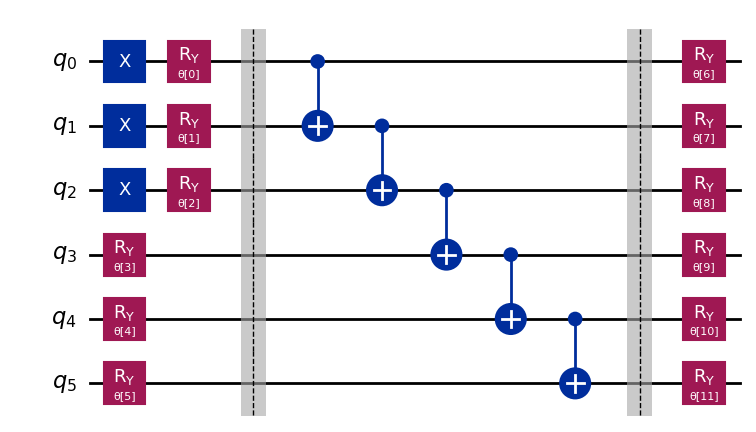

In [29]:
init_state.compose(variational_ansatz(n_qubits,ParameterVector('θ',len(init_params)))).draw("mpl")

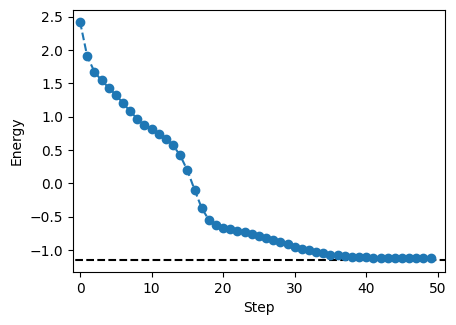

In [30]:
steps = list(range(n_reps))

plt.figure(figsize=(4.8,3.4),dpi=100)
plt.errorbar(steps,np.array(energies_vqe)+nucl_shift,marker='o',linestyle='dashed',label="VQE")
plt.hlines(-1.145, xmin= -10, xmax= 1000,label='Theoretical',linestyle ='dashed',color='black')
plt.xlabel('Step')
plt.xlim(xmin=-1,xmax=51)
plt.ylabel('Energy')

plt.show()

#### Quantum simulation

Now we are going to perform the VQE algorithm for every configuration of the $H_2$ molecule.

In [31]:
# Prepare the backend
estimator = Estimator()
vqe_distances = list(np.arange(0.3, 1.5, .1)) + list(np.arange(1.5, 4.0, .2))

energies["VQE_"+basis] = []
energies["VQE_error"+basis] = []

# Repeat for every r
for (i,r) in enumerate(vqe_distances):
    print("\n=======================================")
    print(f" DISTANCE: {r:0.3}")
    print("=======================================\n")

    molecule    = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, r)], charge=0, multiplicity=1)
    driver      = PySCFDriver.from_molecule(molecule, basis="6-31g")
    problem     = driver.run()
    nucl_shift  = problem.nuclear_repulsion_energy


    # Build the (reduced) qubit operator
    hamiltonian = problem.second_q_ops()[0]
    mapper     = ParityMapper(num_particles=problem.num_particles)
    qubit_op   = mapper.map(hamiltonian)

    # Now create the circuit
    n_qubits   = qubit_op.num_qubits
    params     = np.random.rand(2*n_qubits)
    init_state = HartreeFock(num_spatial_orbitals=problem.num_spatial_orbitals, num_particles=problem.num_particles, qubit_mapper=mapper)

    #Run the algorithm
    n_reps  = 150
    lr = 0.5
    energies_vqe, gradients_vqe = VQE(qubit_op,variational_ansatz,params,init_state,estimator,n_reps,lr)

    print("Final energy: ",energies_vqe[-1]+nucl_shift)

    energies["VQE_"+basis].append(energies_vqe[-1]+nucl_shift)


/var/folders/92/xj8_fzdx36b4vnm1kc6fp7600000gn/T/ipykernel_13949/4156736902.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()



 DISTANCE: 0.3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
Final energy:  -0.6453004078790361

 DISTANCE: 0.4

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137

#### Plot the final results

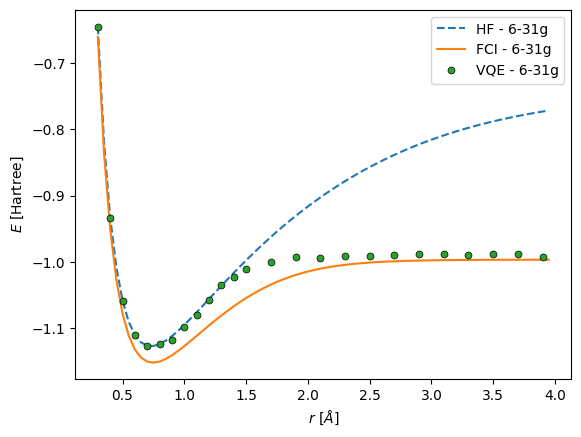

In [32]:
plt.plot(distances,energies["HF_"+basis],linestyle="dashed",label="HF - "+basis)
plt.plot(distances,energies["FCI_"+basis],label="FCI - "+basis)
plt.errorbar(vqe_distances,energies["VQE_"+basis],label="VQE - "+basis,linestyle="",marker="o",markersize=5,mew=0.5,mec="black")

plt.xlabel(r"$r$ [$\AA$]")
plt.ylabel(r"$E$ [Hartree]")
plt.legend()
plt.show()

### Robustness Against Noise
We will now evaluate the performance of the circuit in the presence of noise

In [33]:
!pip install qiskit_ibm_runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.6 MB/s eta 0:00:0000:01m00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 0.58.0
    Uninstalling websocket-client-0.58.0:
      Successfully uninstalled websocket-client-0.58.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

In [34]:
from qiskit_aer import QasmSimulator, StatevectorSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Estimator as AerEstimator
# from qiskit.providers.aer import AerSimulator

In [35]:
from qiskit_ibm_runtime import QiskitRuntimeService

API_KEY = "c83ce05af1d7b31f78e6999d98b0c9b82f54c0f4817d43bf5d264436188a3ecdf59ce96fdea549470cbdb2a67d1c76f797243f1a9fee075dd9f7f7bf49efc734"

# Save your credentials on disk.
QiskitRuntimeService.save_account(channel='ibm_quantum', token=API_KEY)

In [36]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
)

service.backends(simulator=False)

[<IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_sherbrooke')>]

In [37]:
backend = service.backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)
print(noise_model)

NoiseModel:
  Basis gates: ['delay', 'ecr', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'sx', 'ecr', 'id', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
  Specific qubit errors: [('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('x', (7,)), ('x', (8,)), ('x', (9,)), ('x', (10,)), ('x', (11,)), ('x', (12,)), ('x', (13,)), ('x', (14,)), ('x', (15,)), ('x', (16,)), ('

In [38]:
molecule    = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)], charge=0, multiplicity=1)
driver      = PySCFDriver.from_molecule(molecule, basis="6-31g")
problem     = driver.run()
hamiltonian = problem.second_q_ops()[0]

nucl_shift  = problem.nuclear_repulsion_energy


mapper      = ParityMapper(num_particles=problem.num_particles) # Parity mapper requires the spin up and down electrons
qubit_op    = mapper.map(hamiltonian)

We now run our VQE solver on the Noisy Quantum Simulator

In [39]:
# Now create the circuit
n_qubits    = qubit_op.num_qubits
init_params = np.random.rand(2*n_qubits)
init_state  = HartreeFock(num_spatial_orbitals=problem.num_spatial_orbitals, num_particles=problem.num_particles, qubit_mapper=mapper)


n_reps = 50
lr = 0.5
noisy_simulator = AerEstimator(backend_options={"noise_model":noise_model})

energies_vqe, gradients_vqe = VQE(qubit_op,variational_ansatz,init_params,init_state,noisy_simulator,n_reps,lr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


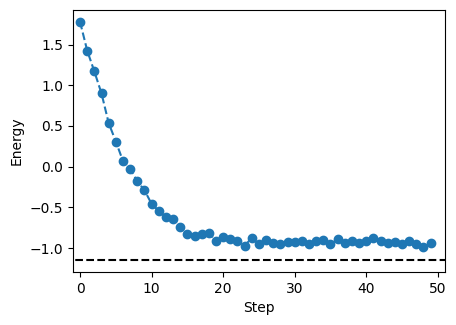

In [40]:
steps = list(range(n_reps))

plt.figure(figsize=(4.8,3.4),dpi=100)
plt.errorbar(steps,np.array(energies_vqe)+nucl_shift,marker='o',linestyle='dashed',label="VQE")
plt.hlines(-1.145, xmin= -10, xmax= 1000,label='Theoretical',linestyle ='dashed',color='black')
plt.xlabel('Step')
plt.xlim(xmin=-1,xmax=51)
plt.ylabel('Energy')

plt.show()

Run the same steps as before but on the noisy simulator

In [42]:
# Prepare the backend
estimator = noisy_simulator
vqe_distances = list(np.arange(0.3, 1.5, .1)) + list(np.arange(1.5, 4.0, .2))

energies["VQE_"+basis] = []
energies["VQE_error"+basis] = []

# Repeat for every r
for (i,r) in enumerate(vqe_distances):
    print("\n=======================================")
    print(f" DISTANCE: {r:0.3}")
    print("=======================================\n")

    molecule    = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, r)], charge=0, multiplicity=1)
    driver      = PySCFDriver.from_molecule(molecule, basis="6-31g")
    problem     = driver.run()
    nucl_shift  = problem.nuclear_repulsion_energy


    # Build the (reduced) qubit operator
    hamiltonian = problem.second_q_ops()[0]
    mapper     = ParityMapper(num_particles=problem.num_particles)
    qubit_op   = mapper.map(hamiltonian)

    # Now create the circuit
    n_qubits   = qubit_op.num_qubits
    params     = np.random.rand(2*n_qubits)
    init_state = HartreeFock(num_spatial_orbitals=problem.num_spatial_orbitals, num_particles=problem.num_particles, qubit_mapper=mapper)

    #Run the algorithm
    n_reps  = 50
    lr = 0.5
    energies_vqe, gradients_vqe = VQE(qubit_op,variational_ansatz,params,init_state,estimator,n_reps,lr)

    print("Final energy: ",energies_vqe[-1]+nucl_shift)

    energies["VQE_"+basis].append(energies_vqe[-1]+nucl_shift)


 DISTANCE: 0.3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Final energy:  -0.3712030997558635

 DISTANCE: 0.4

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Final energy:  -0.6769529007223911

 DISTANCE: 0.5

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Final energy:  -0.8013611211108724

 DISTANCE: 0.6

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Final energy:  -0.90029781745458

 DISTANCE: 0.7

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Final energy:  -0.6359639486901835

 DISTANCE: 0.8

0
1
2
3
4
5
6
7
8
9
10
11

Plot the results

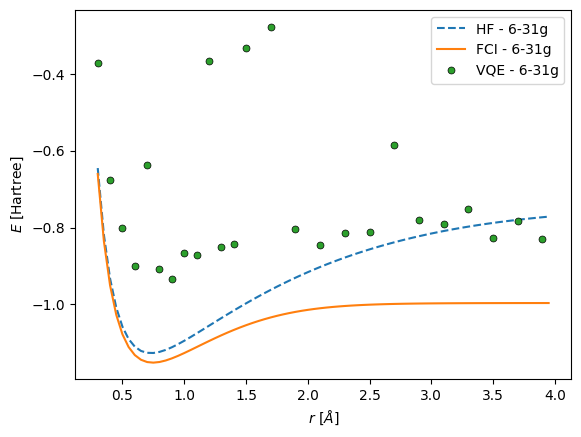

In [43]:
plt.plot(distances,energies["HF_"+basis],linestyle="dashed",label="HF - "+basis)
plt.plot(distances,energies["FCI_"+basis],label="FCI - "+basis)
plt.errorbar(vqe_distances,energies["VQE_"+basis],label="VQE - "+basis,linestyle="",marker="o",markersize=5,mew=0.5,mec="black")

plt.xlabel(r"$r$ [$\AA$]")
plt.ylabel(r"$E$ [Hartree]")
plt.legend()
plt.show()